## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
from IPython.display import clear_output
from random import sample
import string
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        texts = iofile.readlines()

In [3]:
TEXT_START = 45
TEXT_END = -368
texts = text[TEXT_START : TEXT_END]
assert len(texts) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

texts = [text.lower() for text in texts]
text =  ''.join(texts)

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
PADDING = '#'

In [6]:
tokens = sorted(set(text) | {PADDING})

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here
token_to_id = {
    token: idx for idx, token in enumerate(tokens)
}
# dict <char>:<index>
# Your great code here
idx_to_token = {token_to_id[char]: char for char in token_to_id}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [8]:
num_tokens = len(tokens)
num_tokens

39

In [9]:
texts = [text.rstrip().lstrip() for text in texts]

max length = 60


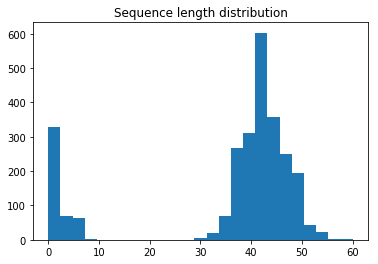

In [10]:
MAX_LENGTH = max(map(len, texts))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, texts)),bins=25);

In [11]:
texts = list(filter(lambda line: len(line) > 25, texts))

In [12]:
texts[::500]

['from fairest creatures we desire increase,',
 'nor thou with public kindness honour me,',
 'and hang more praise upon deceased i',
 "which hath not figur'd to thee my true spirit?",
 'if thou turn back and my loud crying still.']

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [13]:
def padding(text):
    return text + PADDING * (MAX_LENGTH - len(text))

texts = list(map(padding, texts))

In [14]:
def to_index(text):
    return [token_to_id[ch] for ch in text]

encoded = np.array(list(map(to_index, texts)))

In [15]:
texts[::500]

['from fairest creatures we desire increase,##################',
 'nor thou with public kindness honour me,####################',
 'and hang more praise upon deceased i########################',
 "which hath not figur'd to thee my true spirit?##############",
 'if thou turn back and my loud crying still.#################']

In [16]:
encoded

array([[18, 30, 27, ...,  3,  3,  3],
       [32, 20, 13, ...,  3,  3,  3],
       [14, 33, 32, ...,  3,  3,  3],
       ...,
       [18, 27, 30, ...,  3,  3,  3],
       [15, 13, 25, ...,  3,  3,  3],
       [24, 27, 34, ...,  3,  3,  3]])

In [17]:
def get_batches(bs):
    random_idx = np.random.choice(np.arange(0, encoded.shape[0]), size=bs)
    return torch.tensor(encoded[random_idx, :], dtype=int)

In [18]:
class VanillaRNN(nn.Module):
    def __init__(self, num_embeddings=num_tokens, embedding_dim=16, hidden_state_dim=256):
        super().__init__()
        self.hidden_state_dim = hidden_state_dim
        self.embed = nn.Embedding(num_embeddings, embedding_dim)
        self.recur_dense = nn.Linear(hidden_state_dim + embedding_dim, hidden_state_dim)
        self.to_logits = nn.Linear(hidden_state_dim, num_embeddings)
    
    def forward(self, x, hidden_state):
        x = self.embed(x)
        next_hidden = torch.tanh(self.recur_dense(torch.cat((hidden_state, x), dim=1)))
        logits = self.to_logits(next_hidden)
        return next_hidden, logits
    
    def initial_state(self, batch_size):
        return torch.zeros((batch_size, self.hidden_state_dim), 
                           dtype=torch.float32, requires_grad=True)

In [19]:
def RNNLoop(rnn, batch, num_tokens=num_tokens):
    hidden_state = rnn.initial_state(batch.shape[0])
    full_logits = torch.zeros((batch.shape[0], batch.shape[1]-1, num_tokens), dtype=torch.float32)
    for i in range(batch.shape[1]-1):
        hidden_state, logits = rnn(batch.transpose(1, 0)[i], hidden_state)
        full_logits[:, i, :] = logits
    return full_logits

In [20]:
bs = 256
LR = 0.001
rnn = VanillaRNN()
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

Best loss = 0.3145500421524048


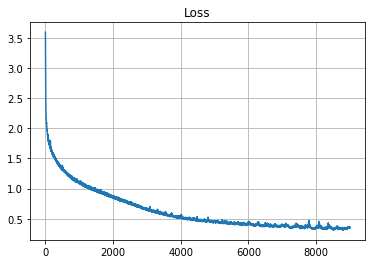

RNN Loss = 0.3472556173801422
Wall time: 1h 10min 2s


In [21]:
%%time
num_epoch = 1000
per_epoch = int(np.ceil(encoded.shape[0] / bs))

best_loss = np.inf
loss_history = []
losses = []
for epoch in range(num_epoch):
    for i in range(per_epoch):
        batch = get_batches(bs)
        RNN_model = RNNLoop(rnn, batch).reshape((-1, num_tokens))
        true_classes = batch[:, 1:].reshape(-1)
        loss = criterion(RNN_model, true_classes)
        loss_history.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=10)
        optimizer.step()
        optimizer.zero_grad()
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(rnn, 'checkpoint_pt/model-rnn')
       
    losses.append(loss.item())
    clear_output(True)
    print(f'Best loss = {best_loss}')
    plt.plot(loss_history)
    plt.grid()
    plt.title("Loss")
    plt.show()
    
print(f'RNN Loss = {losses[-1]}')

Plot the loss function (axis X: number of epochs, axis Y: loss function).

Min loss = 0.31455 at 977 epoch


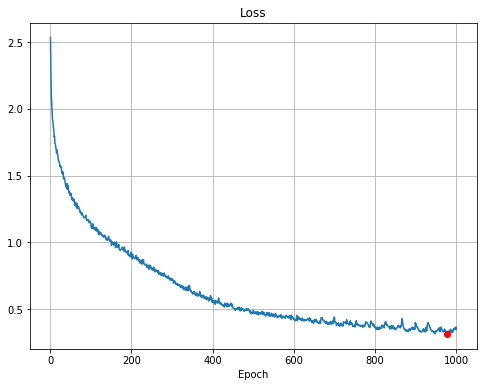

In [22]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses))+1, losses)
plt.plot(np.argmin(losses)+1, np.min(losses), 'ro')
plt.xlabel('Epoch')
plt.title("Loss")
plt.grid()
print(f'Min loss = {np.min(losses):.6} at {np.argmin(losses)+1} epoch')

In [99]:
def generate_sample(char_rnn, max_length=MAX_LENGTH, seed_phrase=' ', temperature=1):
    char_rnn.eval()
    phrase = seed_phrase
    try:
        hidden_state = char_rnn.initial_state(1)
        x_sequence = [token_to_id[token] for token in seed_phrase]
        type_mod = 1
    except:
        hidden_state = None
        x_sequence = [[token_to_id[token]] for token in seed_phrase]
        type_mod = -1
    
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).transpose(1, 0)
    
    with torch.no_grad():
        for char in x_sequence:
            hidden_state, logits = char_rnn(char, hidden_state)
        
        for _ in range(max_length - len(seed_phrase)):
            probs = nn.Softmax(dim=type_mod)(logits / temperature).numpy().flatten()
            next_token_idx = np.random.choice(np.arange(num_tokens), p=probs)
            phrase += idx_to_token[next_token_idx]
            if type_mod == 1:
                token_tensor = torch.tensor([next_token_idx], dtype=torch.int64)
            elif type_mod == -1:
                token_tensor = torch.tensor([[next_token_idx]], dtype=torch.int64)
            hidden_state, logits = char_rnn(token_tensor, hidden_state)   
    return phrase

In [40]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

for i in range(4):
    print(generate_sample(rnn, temperature=0.5, seed_phrase='how ').strip(PADDING).strip('\n '))

how can i then my love sweeriting thine in me;
how to divide, and to compoundance thue time wonds,
how many redouse to sint andents
how can i then return in their eye,


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [61]:
class LSTM(nn.Module):
    def __init__(self, num_embeddings=num_tokens, embedding_dim=16, hidden_state_dim=128):
        super().__init__()
        self.embed = nn.Embedding(num_embeddings, embedding_dim)
        self.recur_dense = nn.LSTM(embedding_dim, hidden_state_dim, batch_first=True)
        self.to_logits = nn.Linear(hidden_state_dim, num_embeddings)
        
    def forward(self, x, hidden_state=None):
        out_hidden, state = self.recur_dense(self.embed(x), hidden_state)
        logits = self.to_logits(out_hidden)
        return state, logits

In [62]:
lstm = LSTM()
optimizer = torch.optim.Adam(lstm.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

Best loss = 0.5157487392425537


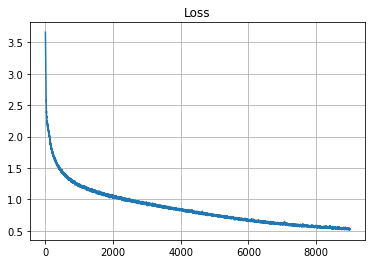

LSTM Loss = 0.5257980823516846
Wall time: 1h 41min 20s


In [63]:
%%time
num_epoch = 1000
per_epoch = int(np.ceil(encoded.shape[0] / bs))

best_loss = np.inf
loss_history = []
losses = []
for epoch in range(num_epoch):
    for i in range(per_epoch):
        batch = get_batches(bs)
        LSTM_model = lstm(batch)[1][:, :-1].reshape((-1, num_tokens))
        true_classes = batch[:, 1:].reshape(-1)
        loss = criterion(LSTM_model, true_classes)
        loss_history.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(lstm.parameters(), max_norm=10)
        optimizer.step()
        optimizer.zero_grad()
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(lstm, 'checkpoint_pt/model-lstm')
        
    losses.append(loss.item())
    clear_output(True)
    print(f'Best loss = {best_loss}')
    plt.plot(loss_history)
    plt.grid()
    plt.title("Loss")
    plt.show()
    
print(f'LSTM Loss = {losses[-1]}')

Min loss = 0.515749 at 973 epoch


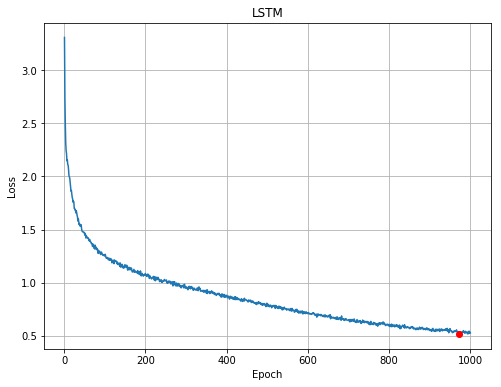

In [64]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses))+1, losses)
plt.plot(np.argmin(losses)+1, np.min(losses), 'ro')
plt.xlabel('Epoch')
plt.title("LSTM")
plt.ylabel("Loss")
plt.grid()
print(f'Min loss = {np.min(losses):.6} at {np.argmin(losses)+1} epoch')

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [105]:
# Text generation with different temperature values here
temperature = [0.1, 0.2, 0.5, 1, 2]

for temp in temperature:
    print(f'\nTemperature: {temp}')
    for i in range(4):
        print(generate_sample(lstm, temperature=temp, seed_phrase='is it ').strip('#\n '))


Temperature: 0.1
is it not singlers restre at in men's
is it not singlers restre at in my sight?
is it not singlers restre at in men's
is it not singlers restre and hearts trimes,

Temperature: 0.2
is it not singlers restre at in men's
is it not singlers my love thee i in tell
is it not singlers restre and hearts trimes,
is it not sick all died in show man of men.

Temperature: 0.5
is it not so thou art she that hid do sige.
is it not singlers resty repensign's eye,
is it not so thinks, them and in my jovent
is it not sick all one doth straight travel'd

Temperature: 1
is it naturer atumence musied bad:
is it be blose grace thou deat love was eye'
is it not might whereity to ryslaness steel.
is it not time's fiful and weil hold day,

Temperature: 2
is it ouw-sead aund and as rudou nughte
is it unure, bir with my rememper.
is it our oury hipel created mine hann:
is it butble alsame ad;# timer rimon.


Увеличение температуры увеличивает разнообразность генерации. Генерация становится менее детерминированной.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [118]:
# Saving and loading code here
path = 'checkpoint_pt/model-rnn'
rnn_model = torch.load(path)

for i in range(4):
    print(generate_sample(rnn_model, temperature=temp, seed_phrase='we are').strip('#\n '))

we are bevelf, as a betters are;:;
we are begies: thy slave you lovtune, bengon: h,# while eas-
we are frief, that love ever-sounl away,
we are belond borned


In [119]:
# Saving and loading code here
path = 'checkpoint_pt/model-lstm'
lstm_model = torch.load(path)

for i in range(4):
    print(generate_sample(lstm_model, temperature=temp, seed_phrase='we are ').strip('#\n '))

we are poresp chert my live happs my passeched
we are thou cond in perpscane estain?
we are thine eye, wil, newing norivicafty had, thry,
we are howb what wasto on ageving fhoov;


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)